In [32]:
import os
import json
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import numpy as np
import sys
import pickle
import time
import matplotlib.pyplot as plt

In [2]:
def load_model(path):
    model = pickle.load(open(path, 'rb'))
    return model

In [3]:
### Load Decision Tree Model
model_path ="/Users/dylan/Twente/Capita Selecta/project/clustering/model"
start_time = time.time()
decision_model_name = "decision_tree_0.6.pkl"
clf = load_model(os.path.join(model_path, decision_model_name))

In [4]:
clf.tree_

In [ ]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

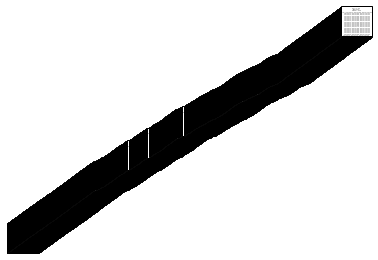

In [20]:
tree.plot_tree(clf)
plt.show()

In [ ]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

In [40]:
def load_dbscan_pickle(model_path):
    ### Load DBScan Model:
    model_name = "dbscan_core_4_0.48.pkl"
    model = load_model(os.path.join(model_path, model_name))
    ### Decision Tree CLASSIFIER
    embedded_vector = model.components_
    train_label = model.labels_
    sample_indice = model.core_sample_indices_
    train_label = train_label[sample_indice]
    thres = float(model_name.split("_")[-1][:3])
    return embedded_vector, train_label, thres

start_time = time.time()
embedded_vector, train_label, thres = load_dbscan_pickle(model_path)
print("--- DBScan Load Model: %s seconds ---" % (time.time() - start_time))


--- DBScan Load Model: 0.18172097206115723 seconds ---


In [41]:
values, counts = np.unique(train_label, return_counts=True)

In [42]:
counts # number of vector label for each position

array([201530,      1,      5, ...,      1,      1,      1])

In [43]:
train_label.shape

(223297,)

In [45]:
len(counts)

5013